In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
import astropy.cosmology.units as cu
import os
import sys
sys.path.insert(0, work)
from illustris_sim import TNGSim
import corrfunc_ls
import tools

#### load in data sets

In [4]:
z = 1.
# initialize simulation and snapshot
sim = TNGSim('TNG300-3', redshift=z)

In [5]:
# luminous red galaxies / emission line galaxies -> tracers
LRG_pos = sim.LRG_pos('DESI', prints=True)
ELG_pos = sim.ELG_pos('DESI', prints=True)

LRG number density for DESI at z=1.0: 1.80e-05 (h/Mpc)^3 
target number of subhalos: 155
ELG number density for DESI at z=1.0: 5.09e-04 (h/Mpc)^3 
target number of subhalos: 4385


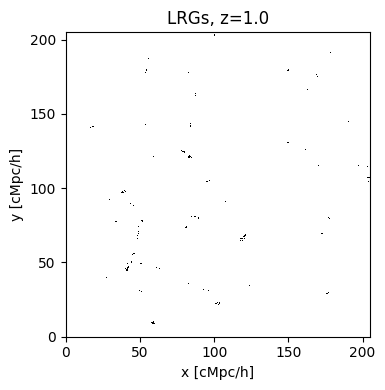

In [9]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(LRG_pos[:,0].value, LRG_pos[:,1].value, ls='None', marker=',', color='k')
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
ax.set_title(f'LRGs, z={z}')
fig.tight_layout()

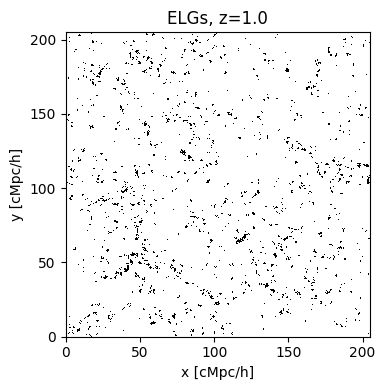

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ELG_pos[:,0].value, ELG_pos[:,1].value, ls='None', marker=',', color='k')
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
ax.set_title(f'ELGs, z={z}')
fig.tight_layout()

#### correlation function parameters

In [11]:
# parameters
randmult = 3
rmin = 1.
rmax = 75.
nbins = 20
nthreads = 12

### gal x gal

In [23]:
ravg, LRG_galxgal = corrfunc_ls.compute_3D_ls_auto(LRG_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)

Text(0.5, 1.0, '2-pt. Gal x Gal (LRG, TNG300-3, z=1.00)')

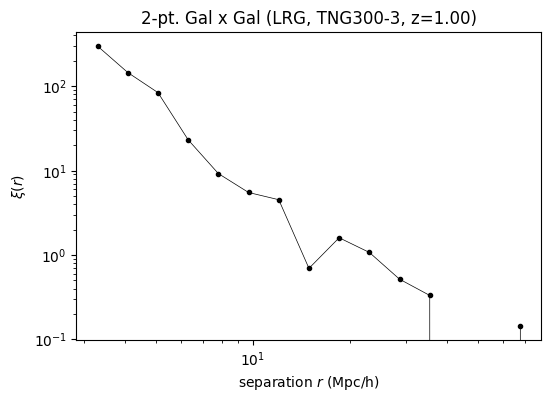

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ravg, LRG_galxgal, 'k.-', lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Gal x Gal (LRG, {sim.sim_tag})')

In [26]:
ravg, ELG_galxgal = corrfunc_ls.compute_3D_ls_auto(ELG_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)

Text(0.5, 1.0, '2-pt. Gal x Gal (ELG, TNG300-3, z=1.00)')

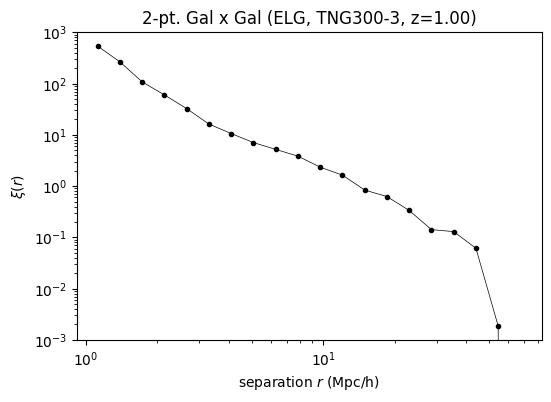

In [27]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ravg, ELG_galxgal, 'k.-', lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Gal x Gal (ELG, {sim.sim_tag})')

#### linear theory from Colossus

In [28]:
xi_lin = tools.linear_2pcf(z, ravg)

#### compare ratios

In [29]:
b_LRG = np.sqrt(LRG_galxgal/xi_lin)
b_ELG = np.sqrt(ELG_galxgal/xi_lin)

/tmp/ipykernel_3804535/1057634700.py:1: RuntimeWarning: invalid value encountered in sqrt
  b_LRG = np.sqrt(LRG_galxgal/xi_lin)
/tmp/ipykernel_3804535/1057634700.py:2: RuntimeWarning: invalid value encountered in sqrt
  b_ELG = np.sqrt(ELG_galxgal/xi_lin)


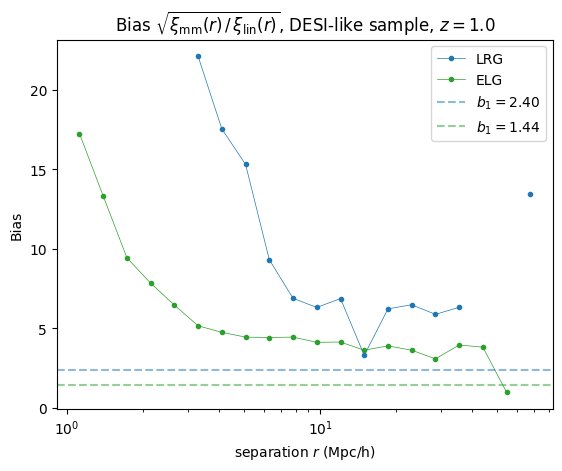

In [30]:
fig, ax = plt.subplots()

ax.plot(ravg, b_LRG, marker='.', lw=0.5, color='C0', label=r'LRG')
ax.plot(ravg, b_ELG, marker='.', lw=0.5, color='C2', label='ELG')
ax.axhline(2.4, color='C0', ls='--', alpha=0.5, label='$b_1=2.40$')
ax.axhline(1.44, color='C2', ls='--', alpha=0.5, label='$b_1=1.44$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'Bias')
ax.set_title(r'Bias $\sqrt{\xi_\mathrm{mm}(r)\,/\,\xi_\mathrm{lin}(r)}$, DESI-like sample, '+f'$z=${z}')
ax.legend()